## Coefficient Reloadable FIR Filter Hardware Design
This notebook demonstrates how to accelerate a function (FIR Filter) from the Processing System (PS) to the Programmable Logic (PL) and how to re-load FIR filter coefficients on a Zynq-7000 using PYNQ. First, a signal comprised of a high and low frequency is generated. Then, the performance of the PS is benchmarked by filtering the signal through both high pass and low pass filters. Lastly, the signal is then sent and received from a low-pass FIR filter implemented in the PL, high-pass FIR coefficients are re-loaded, and the signal is sent and received again. 
### Plot Function

In [60]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None,out_signal2=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=1,label='FIR1 output')
    if out_signal2 is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal2[:n_samples],'b-',linewidth=1,label='FIR2 output')
    plt.legend()

### Generate the Input Signal
Since the fabric clock of the FPGA is at 100MHz we will make our sample rate 100MHz to acheive the best HW performance. The sample rate can be lowered to save resources (DSP Blocks) in the PL however this will minimize the performance increase of utalizing the PL over the PS. The sample rate can also be increased where multiple samples are sent in a single clock cycle in the FPGA (at the expense of resources) - creating a multirate filter. NOTE: The IP must be re-configured and bitstream must be re-generated if the sample rate is changed.

The 2 sets of FIR filter coefficients create a high pass filter at $\omega=0.2$ and a low pass filter at $\omega=0.1$ where $0\leq\omega\leq1$. The signal to be filtered consists of one sinusoid in the passband of the low pass filter and another sinusoid in the passband of the high pass filter.

<IPython.core.display.Javascript object>


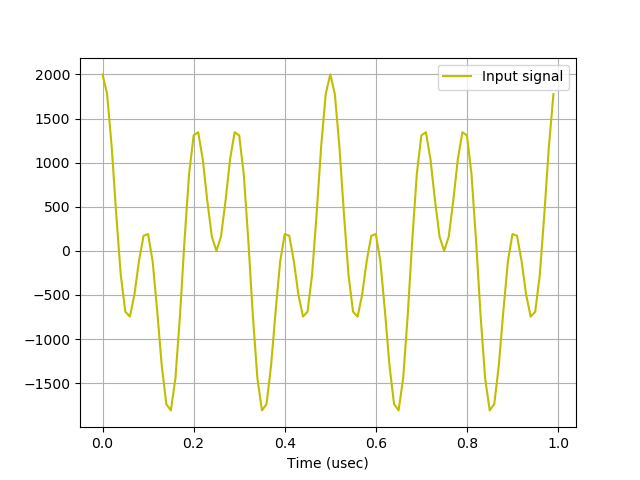

In [61]:
import numpy as np

# Sampling Frequency
Fs = 100e6
# Number of Samples in signal (Default DMA supports single
# Transaction of 2^14 - increased to max of 2^26)
n = 2**19
# Number of Samples to plot in figures
n_plot = 100
# Total Time
T = n/Fs
# Time vector
t = np.linspace(0,T,n,endpoint=False)
# Frequencies
f0 = 10000000
f1 = 4000000
# Samples of the signal
samples = 1000*np.cos(2*np.pi*f0*t) + 1000*np.cos(2*np.pi*f1*t)
samples = samples.astype(np.int32)

# Plot input signal to notebook
plot_to_notebook(t,samples,n_plot)

### Software FIR Filter

Software FIR LPF execution time:  0.23003816604614258 s for  0.00524288 s signal
Software FIR HPF execution time:  0.2537684440612793 s for  0.00524288 s signal


<IPython.core.display.Javascript object>


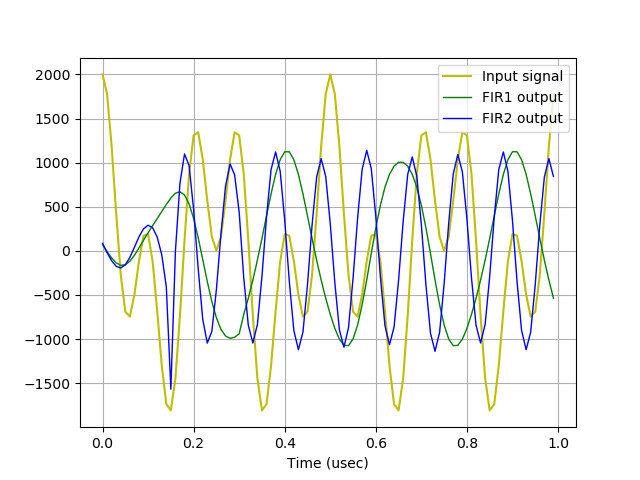

In [63]:
from scipy.signal import lfilter
from numpy import loadtxt

# Perform Low pass first
coeff = loadtxt('/home/xilinx/overlays/fir_reload/low_pass.txt')

import time
start_time = time.time()
sw_fir_lpf_out = lfilter(coeff,1,samples)
stop_time = time.time()
sw_exec_time_lpf = stop_time - start_time

# Perform High pass filtering
coeff = loadtxt('/home/xilinx/overlays/fir_reload/high_pass.txt')

start_time = time.time()
sw_fir_hpf_out = lfilter(coeff,1,samples)
stop_time = time.time()
sw_exec_time_hpf = stop_time - start_time

print('Software FIR LPF execution time: ',sw_exec_time_lpf,'s for ',T,'s signal')
print('Software FIR HPF execution time: ',sw_exec_time_hpf,'s for ',T,'s signal')

# Plot the result to notebook
plot_to_notebook(t,samples,n_plot,out_signal=sw_fir_lpf_out,out_signal2=sw_fir_hpf_out)

### Program FPGA

In [72]:
from pynq import Overlay

# Program PL + load drivers for hardware found in HWH
overlay = Overlay('/home/xilinx/overlays/fir_reload/fir_reload.bit')
# View PL information
#overlay?

### Load Drivers

In [73]:
from pynq.lib import AxiGPIO
from pynq import allocate

# Load FIR Data DMA
dma_fir_data = overlay.axi_dma_fir_data
# Load FIR Reload DMA
dma_fir_reload = overlay.axi_dma_reload
# Load FIR Config DMA
dma_fir_config = overlay.axi_dma_config

### Send Waveform to FIR Filter via DMA with initial coefficients

Hardware FIR execution time:  0.007874250411987305 s for  0.00524288 s signal
Hardware acceleration factor:  29.21397644351591


<IPython.core.display.Javascript object>


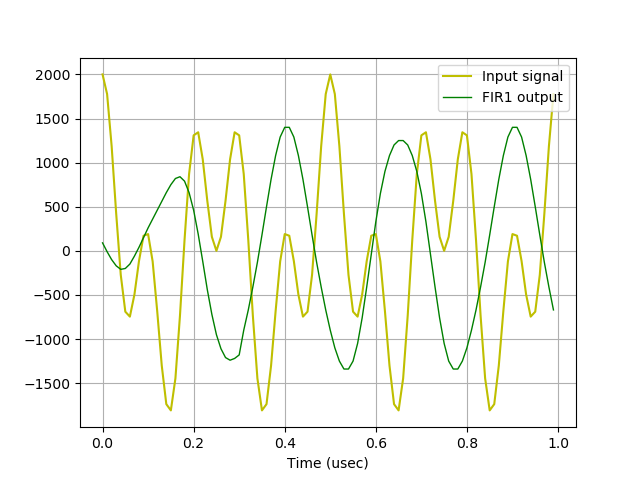

In [74]:
# Allocate physically contiguous buffers for direct register DMA
in_data_buffer = allocate(shape=(n,),dtype=np.int32)
out_data_buffer = allocate(shape=(n,),dtype=np.int32)

# Copy the samples to the input buffer
np.copyto(in_data_buffer,samples)

# Trigger the DMA and wait for the result
start_time = time.time()
dma_fir_data.sendchannel.transfer(in_data_buffer)
dma_fir_data.recvchannel.transfer(out_data_buffer)
dma_fir_data.sendchannel.wait()
dma_fir_data.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time,'s for ',T,'s signal')
print('Hardware acceleration factor: ',sw_exec_time_lpf / hw_exec_time)

# Plot to the notebook
plot_to_notebook(t,samples,n_plot,out_signal=10*out_data_buffer)

out_data_buffer.close()

### Update Low-Pass FIR Filter Coefficients via DMA

In [75]:
# Save initial filter coefficients
init_coeff = loadtxt('/home/xilinx/overlays/fir_reload/low_pass.txt')
# Grab new filter coefficients
coeff = loadtxt('/home/xilinx/overlays/fir_reload/low_pass.txt')
# Re-format (Reload stream uses 16-bit integers)
coeff_hw = np.int16(coeff/np.max(abs(init_coeff)) * 2**15 - 1)
# HW filter is symmetrical so it is only necessary to send half the coefficients
coeff_hw = coeff_hw[0:int(len(coeff_hw)/2)]

# Allocate physically contiguous buffer for direct register DMA (reload)
in_reload_buffer = allocate(shape=(len(coeff_hw),),dtype=np.int16)

# Copy coefficients to buffer
np.copyto(in_reload_buffer,coeff_hw)

# Trigger the DMA read channel
dma_fir_reload.sendchannel.transfer(in_reload_buffer)
dma_fir_reload.sendchannel.wait()


# Send an empty 8-bit packet to FIR config port to complete reload
in_config_buffer = allocate(shape=(1,),dtype=np.int32)
in_config_buffer[0] = 0
dma_fir_config.sendchannel.transfer(in_config_buffer)
dma_fir_config.sendchannel.wait()

# Clear buffers
in_reload_buffer.close()
in_config_buffer.close()

### Send Waveform to FIR via DMA

In [76]:
# Allocate physically contiguous buffers for direct register DMA
out_data_buffer_lpf = allocate(shape=(n,),dtype=np.int32)

# Trigger the DMA and wait for the result
start_time = time.time()
dma_fir_data.sendchannel.transfer(in_data_buffer)
dma_fir_data.recvchannel.transfer(out_data_buffer_lpf)
dma_fir_data.sendchannel.wait()
dma_fir_data.recvchannel.wait()
stop_time = time.time()
hw_exec_time_lpf = stop_time-start_time

hw_samples_lpf = np.empty(shape=(n,),dtype=np.int32)
np.copyto(hw_samples_lpf,out_data_buffer_lpf)

# Clear buffer
out_data_buffer_lpf.close()

### Update High-Pass FIR Filter Coefficients via DMA

In [77]:
# Grab new filter coefficients
coeff = loadtxt('/home/xilinx/overlays/fir_reload/high_pass.txt')
# Re-format (Reload stream uses 16-bit integers)
coeff_hw = np.int16(coeff/np.max(abs(init_coeff)) * 2**15 - 1)
# HW filter is symmetrical so it is only necessary to send half the coefficients
coeff_hw = coeff_hw[0:int(len(coeff_hw)/2)]

# Allocate physically contiguous buffer for direct register DMA (reload)
in_reload_buffer = allocate(shape=(len(coeff_hw),),dtype=np.int16)

# Copy coefficients to buffer
np.copyto(in_reload_buffer,coeff_hw)

# Trigger the DMA read channel
dma_fir_reload.sendchannel.transfer(in_reload_buffer)
dma_fir_reload.sendchannel.wait()


# Send an empty 8-bit packet to FIR config port to complete reload
in_config_buffer = allocate(shape=(1,),dtype=np.int32)
in_config_buffer[0] = 0
dma_fir_config.sendchannel.transfer(in_config_buffer)
dma_fir_config.sendchannel.wait()

# Clear buffers
in_reload_buffer.close()
in_config_buffer.close()

### Send Waveform to FIR via DMA

In [78]:
# Allocate physically contiguous buffers for direct register DMA
out_data_buffer_hpf = allocate(shape=(n,),dtype=np.int32)

# Trigger the DMA and wait for the result
start_time = time.time()
dma_fir_data.sendchannel.transfer(in_data_buffer)
dma_fir_data.recvchannel.transfer(out_data_buffer_hpf)
dma_fir_data.sendchannel.wait()
dma_fir_data.recvchannel.wait()
stop_time = time.time()
hw_exec_time_hpf = stop_time-start_time

hw_samples_hpf = np.empty(shape=(n,),dtype=np.int32)
np.copyto(hw_samples_hpf,out_data_buffer_hpf)

# Clear buffers
out_data_buffer_hpf.close()

### Plot to Notebook

Hardware LPF FIR execution time:  0.0076448917388916016 s for  0.00524288 s signal
Hardware HPF FIR execution time:  0.00758051872253418 s for  0.00524288 s signal
Hardware LPF acceleration factor:  30.090441291127398
Hardware HPF acceleration factor:  33.47639565969492


<IPython.core.display.Javascript object>


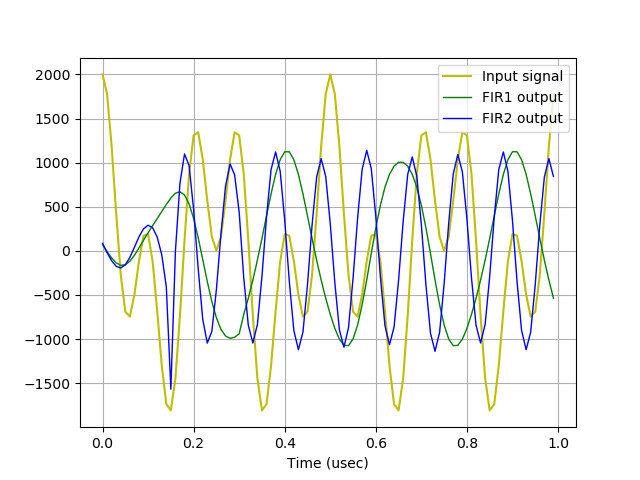

<IPython.core.display.Javascript object>


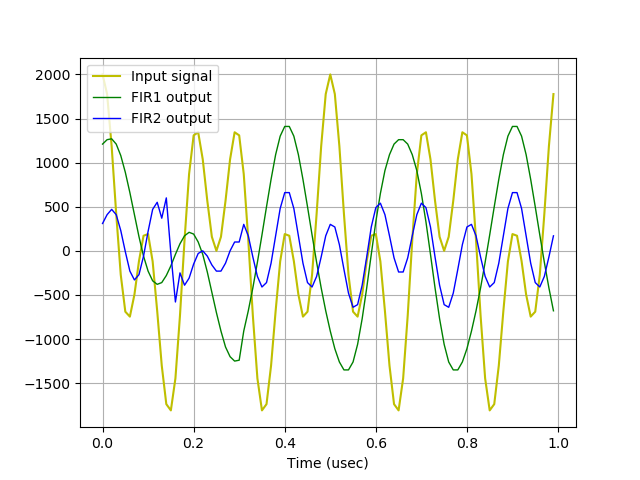

In [71]:
print('Hardware LPF FIR execution time: ',hw_exec_time_lpf,'s for ',T,'s signal')
print('Hardware HPF FIR execution time: ',hw_exec_time_hpf,'s for ',T,'s signal')
print('Hardware LPF acceleration factor: ',sw_exec_time_lpf / hw_exec_time_lpf)
print('Hardware HPF acceleration factor: ',sw_exec_time_hpf / hw_exec_time_hpf)

# Plot to the notebook
plot_to_notebook(t,samples,n_plot,out_signal=sw_fir_lpf_out,out_signal2=sw_fir_hpf_out)
plot_to_notebook(t,samples,n_plot,out_signal=10*hw_samples_lpf,out_signal2=10*hw_samples_hpf)

# Free the buffers
in_data_buffer.close()

Here we can see practically real time filtering. The hardware takes only slightly longer to filter the signal than the actual length of the signal itself. The coe